# **Advanced Lane Lines Finding Project** 
***
This notebook represents project 4 of term 1 of the udacity self driving car nanodegree program. I did use inspiration for this project from this post: https://medium.com/@vivek.yadav/robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3#.l2yuqhqfm

**Part 1** Belows cell performs the following steps of the project
>- Find the camera calibration matrices

---

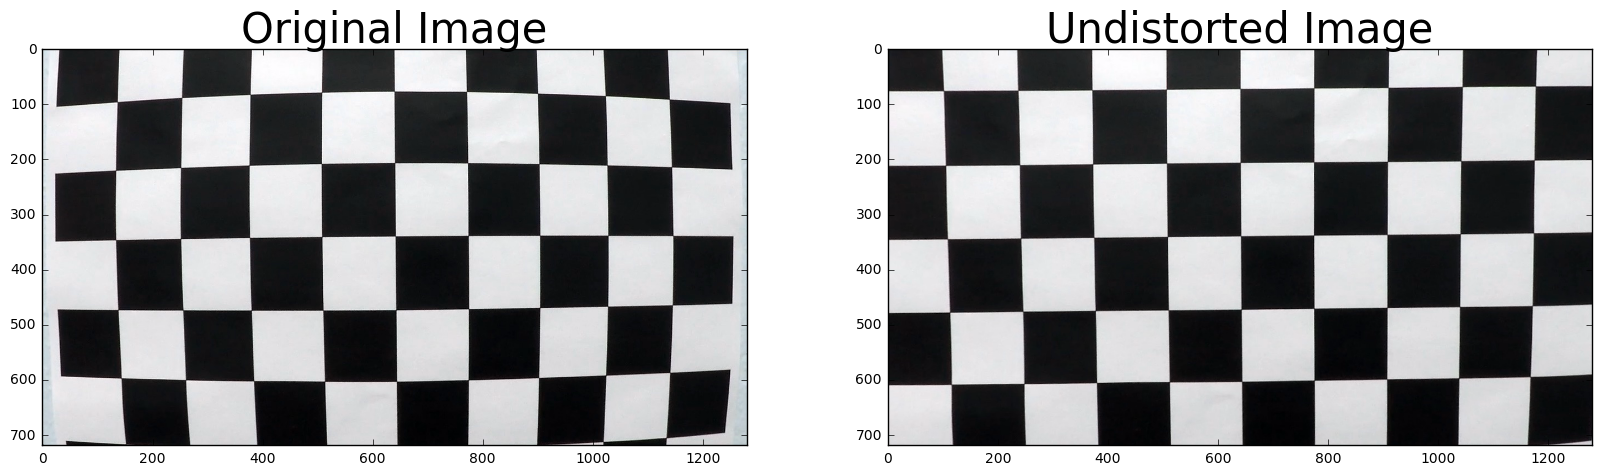

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

nx = 9
ny = 5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Read in image for test and visualization later
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
        
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("calibration_data.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

**Part 2** Belows cells performs the following steps of the project
>- Imports packages needed for the task
>- Defines bespoke functions getting in used in the later defined pipeline

In [2]:
#importing some useful packages and defining some useful functions
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from scipy.misc import imresize
from scipy.interpolate import UnivariateSpline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

training_file='calibration_data.p'

#Bespoke function to get back the value of a polynomial
def get_val(y,pol_a):
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

#Bespoke function to draw lines on image with given points and colors
def draw_pw_lines(img,pts,color):
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

#Bespoke function to undistort image based on previously calculated camera matrices
def undistort_image(img):
    with open(training_file, mode='rb') as f:
        camera_matrices = pickle.load(f)
    mtx = camera_matrices["mtx"]
    dist = camera_matrices["dist"]
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img

#Bespoke function to add gaussian blur to a given image
def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

#Bespoke function to calculate an image of the gradient in x/y direction. Standard is x direction
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

#Bespoke function for warping a given image of the lane to a bird's eye view
def warp_image(img, show_debug=0):
    
    #Calculate destination and source point arrays
    img_size = np.shape(image)
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])
    
    #Transform perspective
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Plot the images in case show debug is set
    if show_debug==1:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(image,cmap='gray')
        for i in range(4):
            plt.plot(src[i][0],src[i][1],'rs')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(warped,cmap='gray')
        for i in range(4):
            plt.plot(dst[i][0],dst[i][1],'rs')
        plt.title('Warped image showing birds eye view')
        plt.axis('off');

    return warped,M,Minv

#Bespoke function getting a color mask and returning it
def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

#Bespoke function getting a color mask and applying it and returning the output
def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

#Bespoke function applying a moving average over a vector provided. n is the filter size
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#Get curvature of a known polynomial representing a fit to a curve
def get_curvature(pol_a,y_pt):
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

#Stack an array to a picture
def stack_arr(arr):
    return np.stack((arr, arr,arr), axis=2)

print('Functions and packages needed for pipeline defined')

Functions and packages needed for pipeline defined


**Part 3** Belows cell performs the following steps of the project
>- Displays the warping function with the end result of a bird's eye view

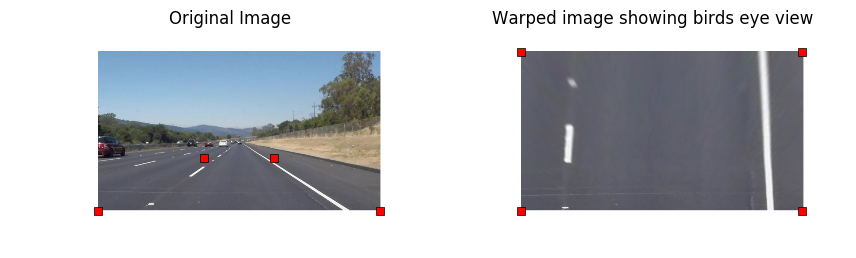

In [3]:
#Read in test image
image=cv2.imread('test_images/solidWhiteRight.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Warp image and show debug output. The points are being marked on the picture
warped,M_warp,Minv_warp = warp_image(undistort_image(image),1)

**Part 4** Belows cells performs the following steps of the project
>- Defines a pipeline function that performs the asked task
>>- Find the curves
>>- Calculate radius of the curve
>>- Calculate the location of the car within the lane
>>- Visualize findings
>- Calls the pipeline function printing out the intermediate steps

In [4]:
#Function that will get called on every video frame when testing on video. Show_debug=1 will lead to plotted intermediate results
def pipeline_process(image,show_debug=0):
    
    global left_fit_prev   
    global right_fit_prev
    global set_prev
    
    col_R = (255,255,255)
    col_L = (255,255,255)

    
    #------------------------------ 1st step undistort image
    
    #Undistort image and apply gaussian blur
    image_undist = undistort_image(image)
    image_undist = gaussian_blur(image_undist, kernel=5)
    
    #Calculate img_size to use later in process
    img_size = np.shape(image_undist)

    # Visualize if show_debug ==1
    if show_debug==1:
        f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
        ax1.imshow(image)
        ax1.set_title('1st step undistort image: Input Image', fontsize=10,fontweight='bold',color='red')
        ax2.imshow(image_undist)
        ax2.set_title('Undistorted Image', fontsize=10)
    
    #------------------------------ 2nd step warp image
    
    #Warp image
    warped,M_warp,Minv_warp = warp_image(image_undist)
    
    # Visualize if show_debug ==1
    if show_debug==1:
        f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
        ax1.imshow(image_undist)
        ax1.set_title('2nd step warp image: Input Image', fontsize=10,fontweight='bold',color='red')
        ax2.imshow(warped)
        ax2.set_title('Warped Image', fontsize=10)
   
    #------------------------------ 3rd step applying color thresholds

    #Convert the image from RGB to HSV color space. This way its easier to apply threshold as lighting conditions do not have big influence on color
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    #Define color thresholds for yellow and white
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])

    #Apply the thresholds individually only the pixels within threshold values are preserved
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    
    #Combine the two images together.
    masked_lane_image = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # Visualize if show_debug ==1
    if show_debug==1:
        f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13,7))
        ax1.imshow(image_HSV,cmap='gray')
        ax1.set_title('3rd step applying color \n thresholds: Input Image', fontsize=10,fontweight='bold',color='red')
        ax2.imshow(mask_yellow,cmap='gray')
        ax2.set_title('Image with yellow color mask', fontsize=10)
        ax3.imshow(mask_white,cmap='gray')
        ax3.set_title('Image with white color mask', fontsize=10)
        ax4.imshow(masked_lane_image,cmap='gray')
        ax4.set_title('Image with combined \n white & yellow color mask', fontsize=10)
    
    #------------------------------4th step calculating gradients

    #Convert the image from RGB to HLS color space as it was shown in the udacity lessons this is more robust than RGB when applying edge detection via gradients
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    
    #Get Hue channel and apply as well an x and y gradient
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    sobel_1 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    #Get Light channel and apply as well an x and y gradient    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    sobel_2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    image_sobel_combined = cv2.bitwise_or(sobel_1,sobel_2)
    image_sobel_combined = gaussian_blur(image_sobel_combined,5)
    
    # Visualize if show_debug ==1
    if show_debug==1:
        f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13,7))
        ax1.imshow(image_HLS,cmap='gray')
        ax1.set_title('4th step calculating \n gradient: Input Image', fontsize=10,fontweight='bold',color='red')
        ax2.imshow(sobel_1,cmap='gray')
        ax2.set_title('Image of gradient \n on H channel', fontsize=10)
        ax3.imshow(sobel_2,cmap='gray')
        ax3.set_title('Image of gradient \n on L channel', fontsize=10)
        ax4.imshow(image_sobel_combined,cmap='gray')
        ax4.set_title('Image of combined gradient \n o H&L channel', fontsize=10)
    
    #------------------------------5th step combining the color masks and gradient
    
    #Combine color mask and gradient images by logic or to finally get image with pixels belonging to lanes set to 1
    image_combined = np.zeros_like(image_sobel_combined)
    image_combined[(masked_lane_image>=.5)|(image_sobel_combined>=.5)]=1

    # Visualize if show_debug ==1
    if show_debug==1:
        f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,7))
        ax1.imshow(image_combined)
        ax1.set_title('5th step combining the color masks \n and gradient: Combined Image', fontsize=10,fontweight='bold',color='red')
        ax2.imshow(masked_lane_image,cmap='gray')
        ax2.set_title('Image of color mask', fontsize=10)
        ax3.imshow(image_sobel_combined,cmap='gray')
        ax3.set_title('Image of calculated gradients', fontsize=10)
    
    #------------------------------6th step finding pixels that the right and left lane in order and fit curve via polyfit to it
    
    image_combined = gaussian_blur(image_combined,5)
    #Moving average filter size
    mov_filtsize = img_size[1]/50.
    #Calculate vector of mean of image columns
    mean_lane = np.mean(image_combined,axis=0)
    #Calculate moving average across before calculated vector. Peaks in this vector indicate a lane as there are lot of pixels then in the neighbourhood of this column indicated as lane pixel
    #Its necessary to calculate this this way as it looks for places where a lot of pixels are masked as lanes making sure single events get filtered out
    mean_lane = moving_average(mean_lane,mov_filtsize)
            
    #Calculate where mean value of moving average is above 0.05 indicating a lane
    arg_fsb = np.argwhere(mean_lane>.05)
        
    #Find peaks in left part of the image
    arg_fsb_L = arg_fsb[arg_fsb<img_size[1]/2.]
    
    #In case no peaks bigger than 0.05 are found go ahead and take curve fit of last frame as there somehow are no lane pixels found
    if len(arg_fsb_L)==0:
        left_fit = left_fit_prev
    
    #If at least 1 peak bigger 0.05 is found start investigating
    else:
        #Find minimum / maximum image column values of assumed pixels for left lane
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        
        #Take image with marked lane pixels and take out portion of image from with column values from minimum to maximum values calculated before
        img_L = np.copy(image_combined)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[1]] = 0
        img_L = gaussian_blur(img_L,25)
    
        #Get all pixels masked as lane pixels from the section from the original image taken above
        vals = np.argwhere(img_L>.5)
        
        #If there are no pixels being masked as lane pixels refer back to curve fit from last frame
        if len(vals)==0:
            left_fit = left_fit_prev
        
        #Fit a polynomial to all pixels presumebly representing the left lane
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            left_fit = np.polyfit(all_x, all_y, 2)
    
    #Find peaks in right part of the image
    arg_fsb_R = arg_fsb[arg_fsb>img_size[1]/2.]
    
    #In case lower than10 peaks bigger than 0.05 are found go ahead and take curve fit of last frame as there somehow are no lane pixels found. 10 is taking as the right image has several small lane segments
    #Its necessary to calculate this this way as it looks for places where a lot of pixels are masked as lanes making sure single events get filtered out
    if len(arg_fsb_R)<10:
        right_fit = right_fit_prev
    
    #If enough peaks bigger than 0.05 are found start investigating
    else:
        #Find minimum / maximum image column values of assumed pixels for right lane
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
    
        #Take image with marked lane pixels and take out portion of image from with column values from minimum to maximum values calculated before
        img_R = np.copy(image_combined)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[1]] = 0
        img_R = gaussian_blur(img_R,25)
    
        #Get all pixels masked as lane pixels from the section from the original image taken above 
        vals = np.argwhere(img_R>.5)
        #If there are not at least 10 pixels corresponding to the 10 peaks above being masked as lane pixels refer back to curve fit from last frame
        if len(vals)<10:
            right_fit = right_fit_prev
        
        #Fit a polynomial to all pixels presumebly representing the right lane
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            right_fit = np.polyfit(all_x, all_y, 2)
            
    # Visualize if show_debug ==1
    if show_debug==1:
        fig=plt.figure()
        plt.plot(mean_lane>.05)
        plt.plot(mean_lane)
        plt.xlabel('image x')
        plt.ylabel('mean intensity')
        fig.suptitle('6th step finding pixels that the right and left lane in order to fit curve to it', fontsize=10,fontweight='bold',color='red')
    
    #------------------------------Intermediate step only valid if first frame 
    
    #If this is the first frame set the current curve fits to also be the ones of the previous frames
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
        
    #------------------------------7th step combining old and new fits making sure to filter out erronous detections
    
    #Calculate the difference between current curve fits and fits from last frame
    err_p_R = np.sum((right_fit-right_fit_prev)**2)/np.sum(right_fit_prev**2)
    err_p_R = np.sqrt(err_p_R)
    
    #In case difference between current frame and laste frame is to big discard it as it seems to be wrong
    if err_p_R>0.05:
        right_fit = right_fit_prev
        left_fit =  left_fit_prev
    
    #If difference between new and old curve fit seems reasonable do a weighted addition of fits hoping that this will add stability to implementation
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        left_fit =  .05*left_fit+.95*left_fit_prev
    
    
    #------------------------------8th step preparing to draw the fits onto the image
    
    #Calculate points right curve from right fit so that one can draw the line
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    #Calculate points left curve from left fit so that one can draw the line
    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]

    #------------------------------9th step calculate the vehicle location in lane
    
    #Get values of left / right curve fit at the bottom of image where the vehicle is located
    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)   

    #Get value of middle of the lane
    val_center = (left_bot+right_bot)/2.0
    
    #Offset between middle of lane and where the vehicle is between the middle of the lane and middle of the image
    #This assumes the camera is in the middle of the vehicle.
    dist_offset = val_center - img_size[1]/2
    
    #Get from pixel space to real distance knowing that based on the width of the lane 1 pixel is about 2.8cm
    dist_offset = (np.round(dist_offset/2.81362,2))
        
    #------------------------------10th step highlight the lane in the original image
        
    #Create empty color image with same dimensions like lane pixel images
    color_warp = np.dstack((np.zeros_like(image_combined).astype(np.uint8), np.zeros_like(image_combined).astype(np.uint8), np.zeros_like(image_combined).astype(np.uint8)))

    #Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    #Fill the pixels in between the lanes boundaries. Color depends on the offset of the vehicle from the middle of the lane
    #Vehicle can get 35cm out of the middle before lane turns red. Else its green
    if dist_offset>35 or dist_offset<-35:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Draw the curves onto the color image with the colored lane created above
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    
    #Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    
    #Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    #------------------------------11th step calculate the radius 
    
    #Calculate the radius of curve
    radius_left_curve = get_curvature(left_fit,img_size[0]/2)
    radius_right_curve = get_curvature(right_fit,img_size[0]/2)
    
    #Create string depicting the curvature measured
    str_curv = 'Curvature: Right = ' + str(np.round(radius_right_curve,2)) + ', Left = ' + str(np.round(radius_left_curve,2))
    
    #Create string depicting the offset of the vehicle from the middle of the lane
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    #Put strings for lane deviation and curvature on image
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, str_curv, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (255,255,255), 2)    
        
    #------------------------------12th step prepare the next cycle with setting the global variables
    
    #Set the curve fit for the previous frame to be the one from this frame in order to use it for the next video frame
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    
    #------------------------------
    
    return result

print('Pipeline defined')

Pipeline defined


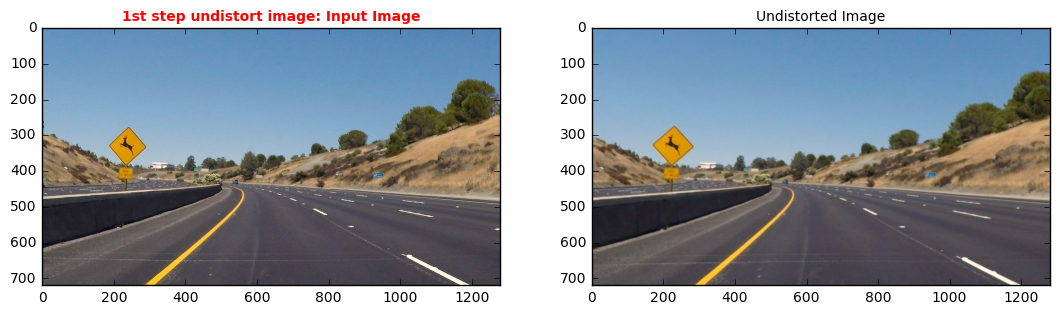

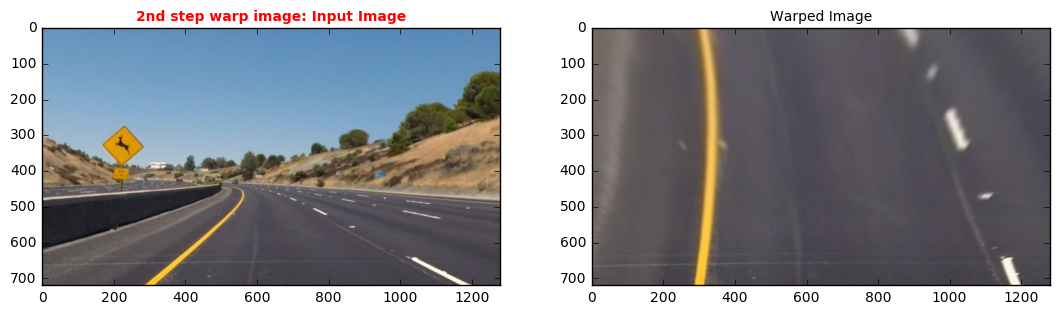

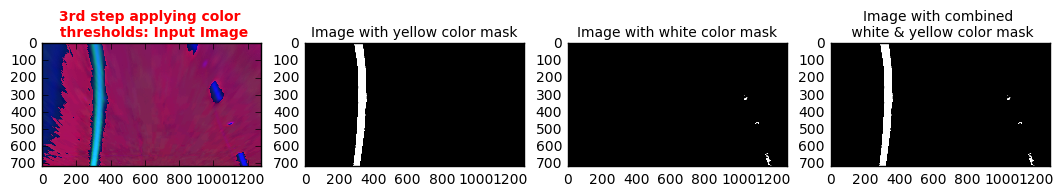

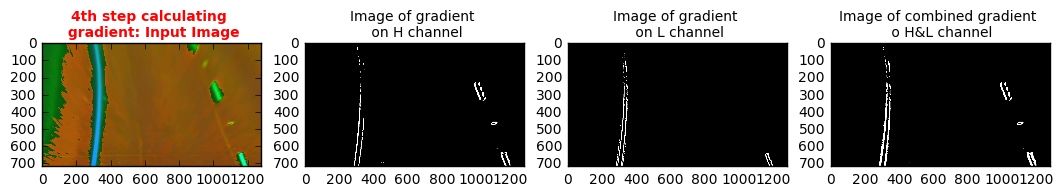

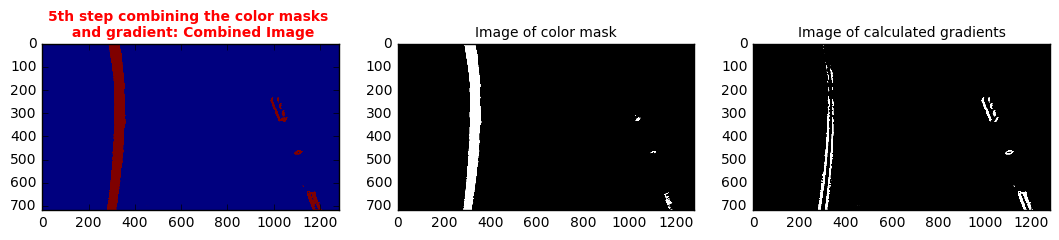

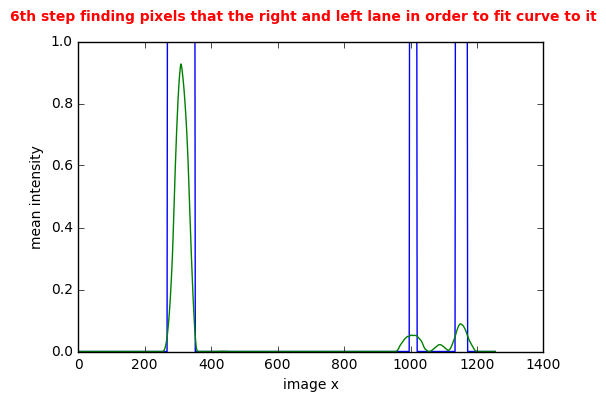

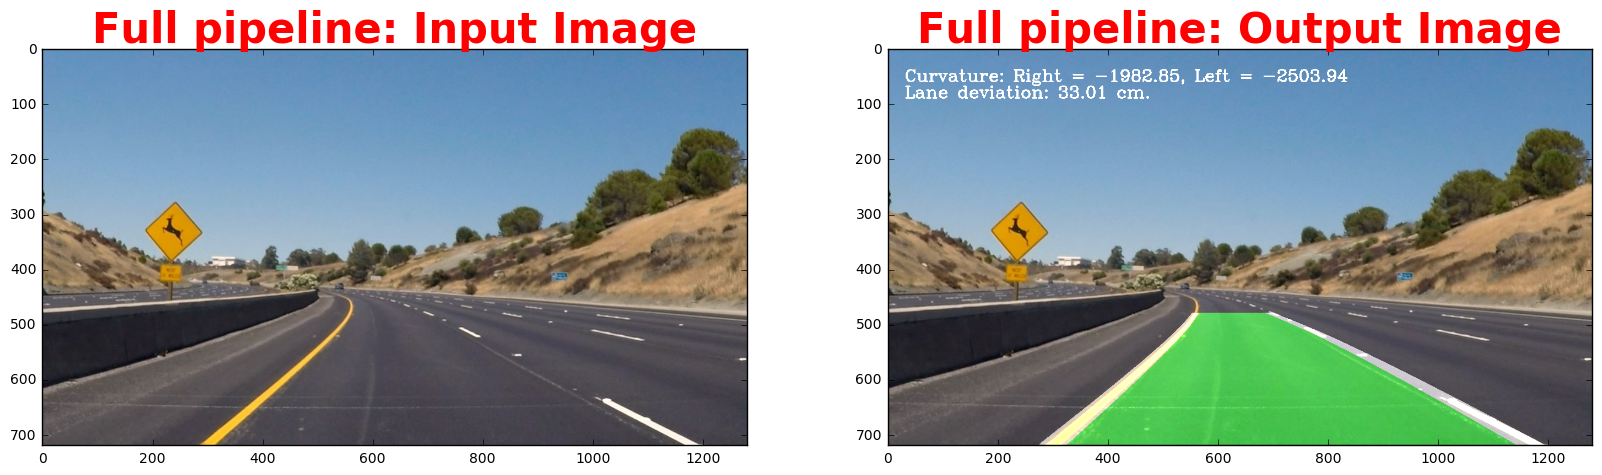

In [5]:
#Read in test image
image=cv2.imread('test_images/test2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Apply pipeline to test image
set_prev = 0
result_pipe = pipeline_process(image, 1)

#Print end result
f_e, (ax_e1,ax_e2) = plt.subplots(1, 2, figsize=(20,10))
ax_e1.imshow(image)
ax_e1.set_title('Full pipeline: Input Image', fontsize=30,fontweight='bold',color='red')
ax_e2.imshow(result_pipe)
ax_e2.set_title('Full pipeline: Output Image', fontsize=30,fontweight='bold',color='red')

**Part 5** Belows cells performs the following steps of the project
>- Reads in video 
>- Performs the pipeline defined above on every frame
>- Saves a video of the pipeline output

In [6]:
set_prev = 0

#Define the output and read in input
project_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4");

#Apply pipeline and write result
result_clip = clip1.fl_image(pipeline_process)
%time result_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:21<00:00,  4.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 5min 23s


**Part 5** Discussion
>- Improvements to be made to make pipeline better:
>>- Imperfect perspective transform should be improved.
>>- Outlier detection is rather simple. Much more elegant would be a model like a Kalmanfilter that takes into account the egomotion of the vehicle. This could be used to discard outliers

>- Challenges and where it will fail
>>- The pipeline has been developed with a lot of assumptions.
>>- It has been only tested with 1 video a number of test images. To be sure a lot more images would be needed
>>- A failure could for example occur at construction sites where lane markings could have a different color than white and yellow
>>- The model could also fail if the lane markings are contradicting for example because of construction sites
>>- The model will also fail if a lane change is happening and the camera is no longer more or less in the middle of the lane
